<a href="https://colab.research.google.com/github/TNH510/Artificial-Intelligence/blob/main/Control_DC_Motor_Servo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Điều khiển hệ thống DC servo dùng fuzzy logic

In [3]:
pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=3a01b76deb6e7b51ed186d512f01d86981e75b6506e4e283e8d7faf5bb862605
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy


In [4]:
import numpy as np
import skfuzzy as fuzzy
from skfuzzy import control as ctrl

In [36]:
#Controller có 2 ngõ vào (sai số e và đạo hàm sai số e), 1 ngõ ra là điện áp V cấp cho động cơ DC
#Chọn khoảng cho e là [0, 1000] (RPM), de/dt là [0, 500], V là [0, 24] (V)
universe = np.linspace(0,1000,61) 
universe1 = np.linspace(0,500,61)
universe2 = np.linspace(0,24,61)
e = ctrl.Antecedent(universe, 'e')
de_dt = ctrl.Antecedent(universe1, 'de_dt')
V = ctrl.Consequent(universe2, 'V')

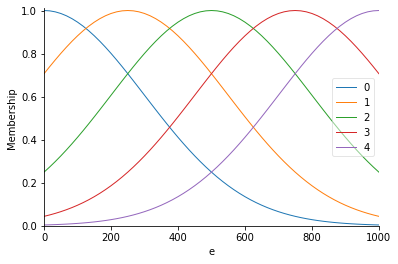

In [37]:
e['0'] = fuzzy.gaussmf(e.universe,0,300)
e['1'] = fuzzy.gaussmf(e.universe,250,300)
e['2'] = fuzzy.gaussmf(e.universe,500,300)
e['3'] = fuzzy.gaussmf(e.universe,750,300)
e['4'] = fuzzy.gaussmf(e.universe,1000,300)
e.view()

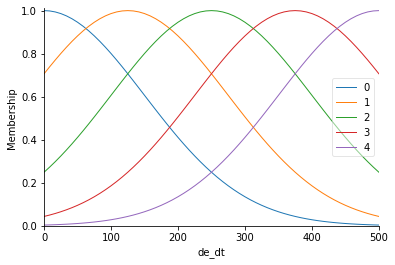

In [38]:
de_dt['0'] = fuzzy.gaussmf(de_dt.universe,0,150)
de_dt['1'] = fuzzy.gaussmf(de_dt.universe,125,150)
de_dt['2'] = fuzzy.gaussmf(de_dt.universe,250,150)
de_dt['3'] = fuzzy.gaussmf(de_dt.universe,375,150)
de_dt['4'] = fuzzy.gaussmf(de_dt.universe,500,150)
de_dt.view()

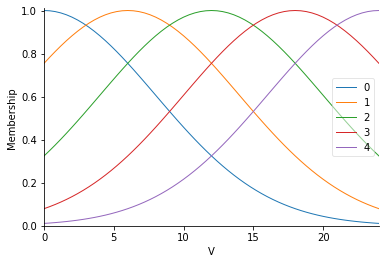

In [39]:
V['0'] = fuzzy.gaussmf(V.universe,0,8)
V['1'] = fuzzy.gaussmf(V.universe,6,8)
V['2'] = fuzzy.gaussmf(V.universe,12,8)
V['3'] = fuzzy.gaussmf(V.universe,18,8)
V['4'] = fuzzy.gaussmf(V.universe,24,8)
V.view()

In [40]:
#Rule
rule0 = ctrl.Rule(antecedent=((e['0']&de_dt['0'])|(e['0']&de_dt['1'])|(e['1']&de_dt['0'])|(e['0']&de_dt['2'])|
                              (e['2']&de_dt['0'])), consequent= V['0'])

rule1 = ctrl.Rule(antecedent=((e['3']&de_dt['0'])|(e['0']&de_dt['3'])|(e['2']&de_dt['1'])|(e['1']&de_dt['2'])|
                              (e['1']&de_dt['1'])), consequent= V['1'])

rule2 = ctrl.Rule(antecedent=((e['0']&de_dt['4'])|(e['4']&de_dt['0'])|(e['1']&de_dt['3'])|
                              (e['3']&de_dt['1'])|(e['2']&de_dt['2'])), consequent= V['2'])

rule3 = ctrl.Rule(antecedent=((e['4']&de_dt['1'])|(e['1']&de_dt['4'])|(e['3']&de_dt['2'])|(e['2']&de_dt['3'])|
                              (e['3']&de_dt['3'])), consequent= V['3'])

rule4 = ctrl.Rule(antecedent=((e['4']&de_dt['4'])|(e['4']&de_dt['3'])|(e['3']&de_dt['4'])|(e['4']&de_dt['2'])|
                              (e['2']&de_dt['4'])), consequent= V['4'])
     

In [41]:
from matplotlib.legend import time
import matplotlib
from skfuzzy.control.controlsystem import ControlSystemSimulation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

System  = ctrl.ControlSystem(rules = [rule1, rule2, rule3, rule4, rule0])
sim = ctrl.ControlSystemSimulation(System, flush_after_run= 61*61+1)
upSampled1 = np.linspace(0,1000,61)
upSampled2 = np.linspace(0,500,61)
x,y = np.meshgrid(upSampled1, upSampled2)
z = np.zeros_like(x)


In [42]:
for i in range(61):
  for j in range(61):
    sim.input['e']= x[i,j]
    sim.input['de_dt']=y[i,j]
    sim.compute()
    z[i,j]=sim.output['V']

<ipython-input-43-fa9b9cd9e49f>:5: UserWarning: The following kwargs were not used by contour: 'anpha'
  cset = ax.contourf(x,y,z, zdir= 'z', offset= 6, cmap= 'viridis', anpha= 0.5)
<ipython-input-43-fa9b9cd9e49f>:6: UserWarning: The following kwargs were not used by contour: 'anpha'
  cset = ax.contourf(x,y,z, zdir= 'x', offset= 6, cmap= 'viridis', anpha= 0.5)
<ipython-input-43-fa9b9cd9e49f>:7: UserWarning: The following kwargs were not used by contour: 'anpha'
  cset = ax.contourf(x,y,z, zdir= 'y', offset= 6, cmap= 'viridis', anpha= 0.5)


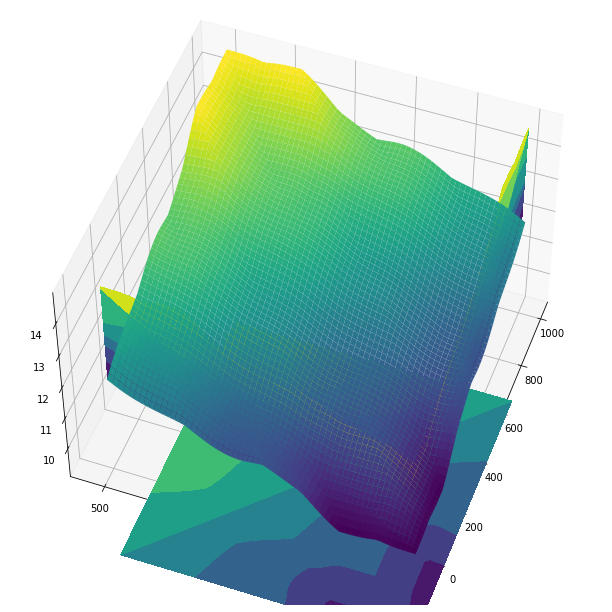

In [43]:
fig = plt.figure(figsize =(11,11))
ax = fig.add_subplot(111,projection = '3d')
suf = ax.plot_surface(x,y,z, rstride= 1, cstride= 1, cmap = 'viridis',
                      linewidth= 0.4, antialiased= True)
cset = ax.contourf(x,y,z, zdir= 'z', offset= 6, cmap= 'viridis', anpha= 0.5)
cset = ax.contourf(x,y,z, zdir= 'x', offset= 6, cmap= 'viridis', anpha= 0.5)
cset = ax.contourf(x,y,z, zdir= 'y', offset= 6, cmap= 'viridis', anpha= 0.5)
ax.view_init(50,200)